<a href="https://colab.research.google.com/github/nsubbaian/BayesianML/blob/master/Project3/BayesMLProject3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement two different linear classifiers on the data in the attached file, a Gaussian generative model, and a logistic regression classifier. For the logistic regression classifier, you must implement the IRLS algorithm. You will need to use a 3rd basis function to separate the circles data, but you can operate directly in the feature space for the unimodal data.

Report your % correct classification (it should be very high for these simple datasets).

Plot a ROC curve for both of your classifiers, Plot the decision boundary for both your classifiers for the unimodal data. (you can skip this for the circle one).

Next, Go to Kaggle or the UCI machine learning database, find a dataset that interests you, and try your classifiers on it. Make sure it is a binary dataset with only numerical features. Plot an ROC and report the % correctly classified.

In [8]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import multivariate_normal


# Helpful Resources
# https://www.youtube.com/playlist?list=PL_onPhFCkVQhUzcTVgQiC8W2ShZKWlm0s 
# http://mi.eng.cam.ac.uk/~mjfg/local/4F10/lect2.pdf
# https://archive.ics.uci.edu/ml/datasets/Wine 

In [9]:
!wget https://github.com/nsubbaian/BayesianML/blob/master/Project3/mlData.mat?raw=true
!mv mlData.mat\?raw\=true mlData.mat

matdata = scipy.io.loadmat('mlData.mat')

--2020-12-05 20:09:11--  https://github.com/nsubbaian/BayesianML/blob/master/Project3/mlData.mat?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/nsubbaian/BayesianML/raw/master/Project3/mlData.mat [following]
--2020-12-05 20:09:11--  https://github.com/nsubbaian/BayesianML/raw/master/Project3/mlData.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nsubbaian/BayesianML/master/Project3/mlData.mat [following]
--2020-12-05 20:09:11--  https://raw.githubusercontent.com/nsubbaian/BayesianML/master/Project3/mlData.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP re

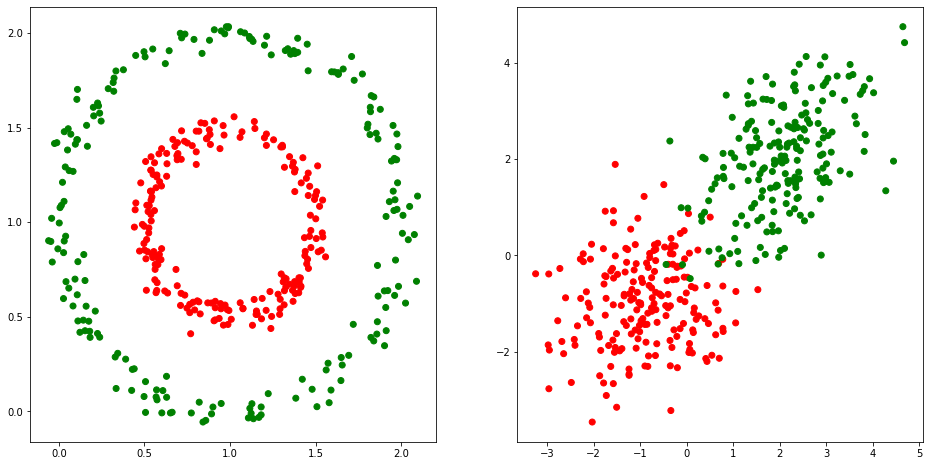

In [10]:
# ----------------- Data -------------------------------
circles_xy = matdata['circles'][0][0][0]
unimodal_xy = matdata['unimodal'][0][0][0]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
colors = ['red','green']

xc, yc = map(list,zip(*circles_xy))
lc = matdata['circles'][0][0][1]
axs[0].scatter(xc, yc, c=lc, cmap=matplotlib.colors.ListedColormap(colors))

xu, yu = map(list,zip(*unimodal_xy))
lu = matdata['unimodal'][0][0][1]
axs[1].scatter(xu, yu, c=lu, cmap=matplotlib.colors.ListedColormap(colors))

 ### Gaussian generative model

Unimodal Data accuracy: 92.5
Circles Data accuracy: 100.0


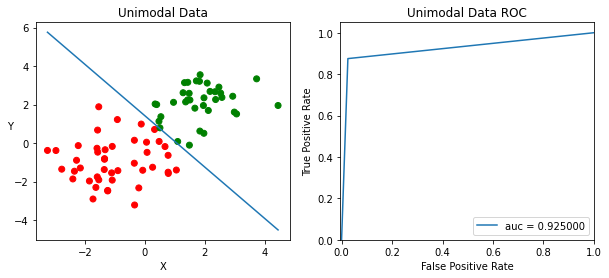

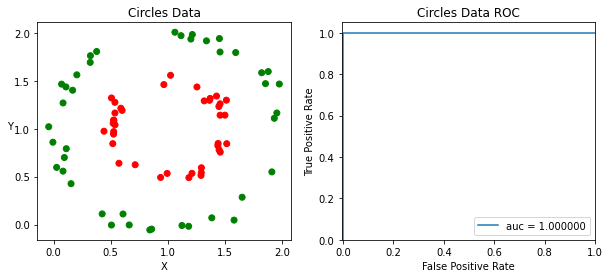

In [11]:
def GGM(coordinates, label, isCircle):
    x_train, x_test, t_train, t_test = train_test_split(coordinates, label.squeeze(), test_size=0.2)

    N = len(x_train) 
    N1 = np.sum(t_train)
    N2 = N-N1 

    # EQ 4.75 and 4.76 from textbook
    mu1 = np.sum(t_train * x_train.T, axis = 1)/N1
    mu2 = np.sum((1-t_train) * x_train.T, axis = 1)/N2 
    
    # EQ 4.78 - 4.80
    S1 = np.matmul((x_train-mu1).T, (x_train-mu1))/N1
    S2 = np.matmul((x_train-mu2).T,(x_train-mu2))/N2
    S = (N1/N)*S1 + (N2/N)*S2
    
    t = []
    for i in x_test: t.append(multivariate_normal.pdf(i, mu1, S)> multivariate_normal.pdf(i, mu2, S))
  
    # Plot Decision Boundary
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    xc, yc = map(list,zip(*x_test[:,:2]))

    if not isCircle: 
        pi1 = N1/float(N1 + N2)
        pi2 = 1-pi1
        x_db = np.linspace(min(xc),max(xc),100)
        b1T = 2.0*np.linalg.inv(S).dot((mu1 - mu2))[0]
        b2T = 2.0*np.linalg.inv(S).dot((mu1 - mu2))[1]
        c = (-mu1.dot(np.linalg.inv(S).dot(mu1))) + (mu2.dot(np.linalg.inv(S).dot(mu2))) + (np.log(pi1/(pi2)))
        y_db = (-c - b1T*x_db)/b2T
        ax[0].plot(x_db,y_db)
        title = 'Unimodal Data'
    else:
        title = 'Circles Data'
    
    ax[0].scatter(xc, yc, c=t, cmap=matplotlib.colors.ListedColormap(colors))
    ax[0].set_title(title)
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y', rotation=0)

    # Plot ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(t_test,t)
    auc = metrics.auc(fpr, tpr)
    ax[1].set_title(title +' ROC')
    ax[1].plot(fpr, tpr, label = 'auc = %f' % auc)
    ax[1].legend(loc = 'lower right')
    ax[1].set_xlim([-0.005, 1])
    ax[1].set_ylim([0, 1.05])
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_xlabel('False Positive Rate')

    print(title, "accuracy:", np.sum(t == t_test)/len(t_test) *100)
    fig.show()

# Unimodal Data
GGM(unimodal_xy, lu, False)


# Circles Data w/3rd basis function
circles_xy_with3rd = np.concatenate((circles_xy,np.expand_dims(((1 + np.exp(-circles_xy[:,0]))**-1)+((1 + np.exp(-circles_xy[:,1]))**-1),1)),axis =1)
GGM(circles_xy_with3rd,lc, True)

### Logistic regression classifier
 IRLS algorithm  using a 3rd basis function to separate the circles data

Unimodal accuracy: 95.0
Circles accuracy: 100.0


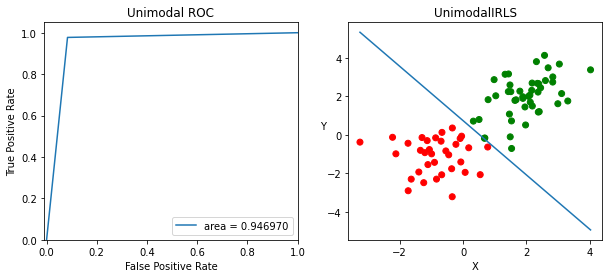

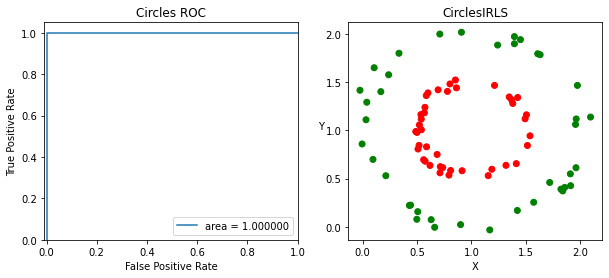

In [12]:
def IRLS(coordinates, label, displayplot, title):

    x_train, x_test, t_train, t_test = train_test_split(coordinates, label.squeeze(), test_size=0.2)
    p = np.concatenate((np.ones((len(x_train),1)), x_train), axis=1)
    w = np.zeros((p.shape[1]))
    
    for i in range(15):
        yn = (1 + np.exp(-np.matmul(w,p.T)))**(-1)

        # weighting matrix R, EQ 4.98
        R = np.matmul(np.expand_dims(yn,1), np.expand_dims((1-yn),1).T)*np.eye(len(yn))

        # The Newton-Raphson update formula for the logistic regression model, EQ 4.99
        w = np.matmul(np.matmul(np.linalg.pinv(np.matmul(np.matmul(p.T, R), p)),p.T), np.matmul(R, np.matmul(p,w))-(yn-t_train))

    p_test = np.concatenate((np.ones((len(x_test),1)),x_test), axis=1)
    t = np.round((1 + np.exp(-np.matmul(w, p_test.T)))**-1)

    if displayplot:
      fig, ax = plt.subplots(1, 2, figsize=(10, 4))
      xc, yc = map(list,zip(*x_test[:,:2]))
      ax[1].scatter(xc, yc, c=t, cmap=matplotlib.colors.ListedColormap(colors))
      ax[1].set_title(title +  'IRLS')
      ax[1].set_xlabel('X')
      ax[1].set_ylabel('Y', rotation =0)
      
      if title == 'Unimodal': 
        x = np.linspace(min(xc),max(xc),100)
        y = ((- w[0] -w[1]*x))/w[2]
        ax[1].plot(x, y)
    else:
      fig, ax = plt.subplots(1, 2, figsize=(10, 4))
      ax[1].axis('off')

    # Plot ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(t_test,t)
    area = metrics.auc(fpr, tpr)   
    ax[0].plot(fpr, tpr, label = 'area = %f' %area)
    ax[0].legend(loc = 'lower right')
    ax[0].set_xlim([-0.01, 1])
    ax[0].set_ylim([0, 1.05])
    ax[0].set_title( title +' ROC')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    print(title, 'accuracy:', (len(t)- sum(abs(t-t_test)))/len(t)*100)
    fig.show()


# Unimodal Data
IRLS(unimodal_xy, lu.squeeze(), True, 'Unimodal')

# Circles Data w/3rd basis function
circles_xy_with3rd = np.concatenate((circles_xy, np.expand_dims(((1 + np.exp(-circles_xy[:,0]))**-1)+((1 + np.exp(-circles_xy[:,1]))**-1),1)),axis =1)
IRLS(circles_xy_with3rd,lc, True, 'Circles')

### Repeat above using UCI dataset

Wine data accuracy: 92.3076923076923


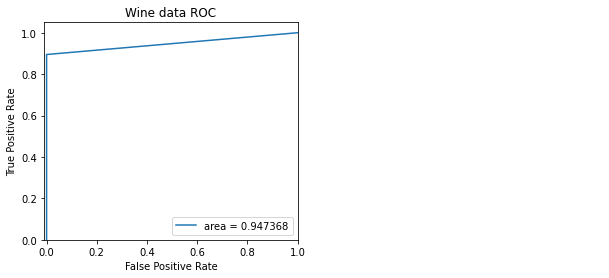

In [13]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',  sep = ',',  names = ['Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'phenols', 'Flavanoids',
                                                                                                        'Nonflavanoid ', 'Proanthocyanins','Color', 'Hue', ' OD280', 'Proline'])
df = df.reset_index()
df = df[df['index'] <3]
df['index'] = df['index']-1
IRLS(np.asarray(df[['Alcohol','Malic', 'Alcalinity']]),df['index'].values, False, 'Wine data')